In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix,\
    accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

!pip install sklearn_hierarchical_classification

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/UFF/TCC/Implementação/

/content/drive/MyDrive/UFF/TCC/Implementação


In [4]:
df = pd.read_csv('forth_trace.csv')

activities_labels = list(range(1,8))
transitions_labels = list(range(8,17))

X = df.drop(columns=['class'])
y = df['class']

metrics = ['f1_weighted', 'balanced_accuracy', 'accuracy']

In [5]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

## Hierarchy Definition

In [6]:

class_hierarchy = {
    ROOT: ["T", "NT"],
    "NT": activities_labels,
    "T": transitions_labels
}

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 1600,
                    hidden_layer_sizes=(500,),
                    random_state=42),
    "T": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 1600,
                    hidden_layer_sizes=(50,),
                    random_state=42),
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)

In [7]:
result = cross_validate(clf, X, y, cv=10, scoring=metrics,
                        return_train_score=True, n_jobs=-1)

print("\tf1:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_f1_weighted').mean()*100,
            std = result.get('test_f1_weighted').std()))

print("\tbalanced accuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_balanced_accuracy').mean()*100,
            std = result.get('test_balanced_accuracy').std()))

print("\taccuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
      .format(mean = result.get('test_accuracy').mean()*100,
              std = result.get('test_accuracy').std()))

	f1:
		mean = 60.33%;
		std = 0.05;
	balanced accuracy:
		mean = 43.94%;
		std = 0.05;
	accuracy:
		mean = 60.79%;
		std = 0.05;


In [8]:
acc = cross_val_score(clf, X=X, y=y, cv=10,
                      scoring=make_scorer(
                          classification_report_with_accuracy_score
                      ))

print("Accuracy")
print("mean = {mean:.2f}%;\tstd = {std:.2f};"
      .format(mean = acc.mean()*100,
              std = acc.std()))

# Average values in classification report for all folds in a K-fold Cross-validation
print(classification_report(originalclass, predictedclass))

Accuracy
mean = 60.79%;	std = 0.05;
              precision    recall  f1-score   support

           1       0.85      0.89      0.87      4081
           2       0.63      0.64      0.63      2189
           3       0.61      0.55      0.58      2202
           4       0.52      0.54      0.53      3664
           5       0.54      0.54      0.54      3670
           6       0.66      0.59      0.63      2328
           7       0.35      0.42      0.38      1178
           8       0.37      0.31      0.33       163
           9       0.28      0.27      0.27       147
          10       0.27      0.29      0.28       160
          11       0.28      0.26      0.27       147
          12       0.46      0.33      0.38       100
          13       0.41      0.34      0.37       200
          14       0.75      0.61      0.67       100
          15       0.34      0.28      0.31        50
          16       0.27      0.18      0.22        50

    accuracy                           0.61 

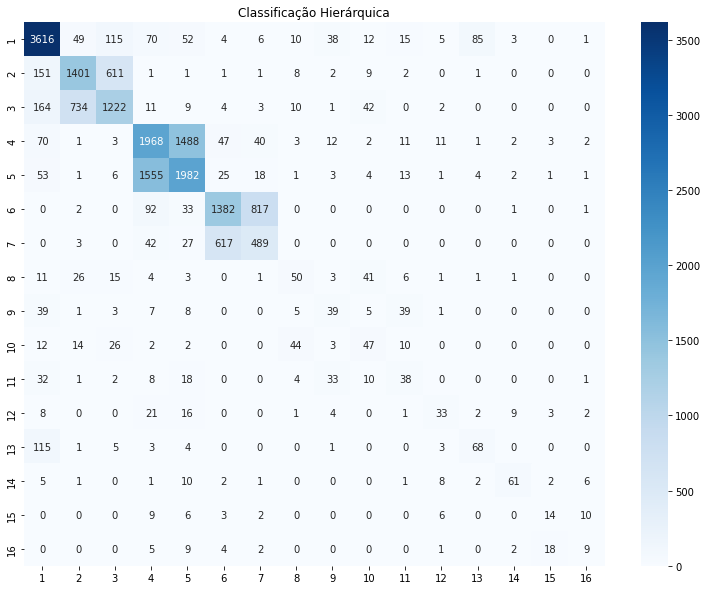

In [9]:
cf_matrix = confusion_matrix(originalclass, predictedclass)

categories = np.unique(y).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Hierárquica')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)
